In [18]:
import pandas as pd

# 경로
BASE_PATH = "clean_vote_ver2/"

# 데이터 로드
payment = pd.read_csv(BASE_PATH + "processed_accounts_paymenthistory.csv")
users = pd.read_csv(BASE_PATH + "processed_accounts_user.csv")

# 컬럼 확인
print(payment.columns)

Index(['user_id', 'productId', 'phone_type', 'created_at'], dtype='object')


In [19]:
# 결제 성공만 필터
if "status" in payment.columns:
    payment = payment[payment["status"] == "SUCCESS"]

In [20]:
purchase_summary = (
    payment
    .groupby("user_id")
    .agg(
        purchase_count=("user_id", "count"),
        first_purchase=("created_at", "min"),
        last_purchase=("created_at", "max")
    )
    .reset_index()
)

In [21]:
purchase_user = purchase_summary.merge(
    users,
    on="user_id",
    how="left"
)

print(purchase_user.head())

   user_id  purchase_count       first_purchase        last_purchase gender  \
0   833041               2  2023-05-14 16:59:46  2023-05-15 10:50:06      F   
1   834112               1  2023-05-22 08:55:46  2023-05-22 08:55:46      F   
2   835815               3  2023-06-10 23:17:45  2023-06-10 23:19:17      F   
3   835839               1  2023-05-16 01:37:30  2023-05-16 01:37:30      M   
4   835888               2  2023-06-06 13:58:49  2023-06-06 13:59:22      M   

         point                                     friend_id_list  is_push_on  \
0  885000006.0  [841345, 982531, 838785, 882567, 832520, 87949...         1.0   
1        915.0  [835713, 846722, 835714, 836487, 845325, 85006...         1.0   
2        100.0  [1012807, 905511, 974222, 862865, 858838, 9828...         1.0   
3       2710.0  [1376386, 1165700, 1124100, 1140494, 1275925, ...         0.0   
4        239.0  [1447168, 971265, 1053698, 1101569, 1068038, 9...         1.0   

            created_at block_user_id_l

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

payment = pd.read_csv("clean_vote_ver2/processed_accounts_paymenthistory.csv")

# 날짜 변환
payment["created_at"] = pd.to_datetime(payment["created_at"])

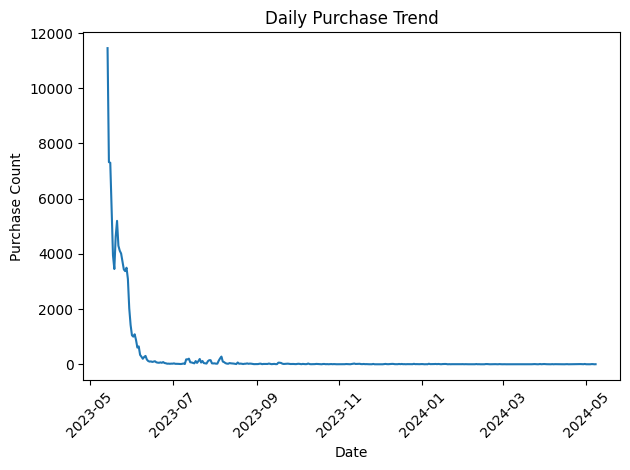

In [23]:
daily_purchase = (
    payment
    .groupby(payment["created_at"].dt.date)
    .size()
)

plt.figure()
daily_purchase.plot()
plt.title("Daily Purchase Trend")
plt.xlabel("Date")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

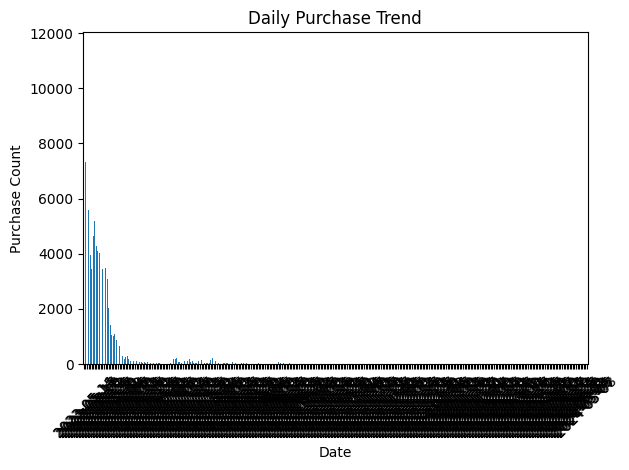

In [24]:
plt.figure()

daily_purchase.plot(kind="bar")

plt.title("Daily Purchase Trend")
plt.xlabel("Date")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/var/folders/v1/k2x8lm750mbb_z0sj197vzrh0000gn/T/ipykernel_22842/3450724552.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")   # 월별 집계


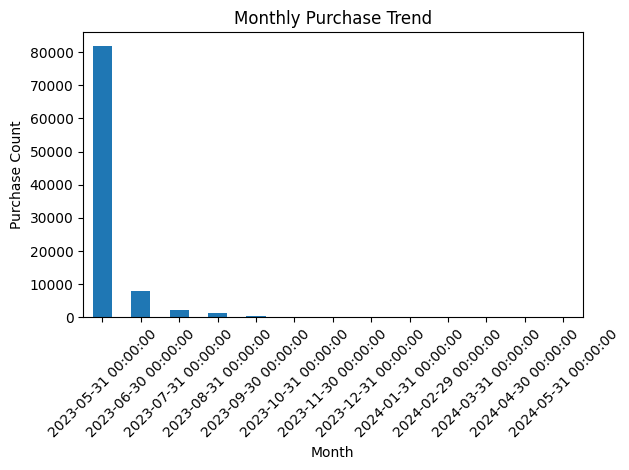

In [25]:
import matplotlib.pyplot as plt

# created_at을 인덱스로
payment["created_at"] = pd.to_datetime(payment["created_at"])

monthly_purchase = (
    payment
    .set_index("created_at")
    .resample("M")   # 월별 집계
    .size()
)

plt.figure()

monthly_purchase.plot(kind="bar")

plt.title("Monthly Purchase Trend")
plt.xlabel("Month")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

- 선 그래프 기준으로 추가 확인
- 구매가 감소하는 경계 필요

In [26]:
# 일별 구매량
daily_purchase = (
    payment
    .groupby(payment["created_at"].dt.date)
    .size()
)

In [27]:
# 로그 변환
import numpy as np

log_purchase = np.log1p(daily_purchase)

In [28]:
# 기울기
change_rate = log_purchase.diff()

In [29]:
# 변화율이 안정되는 최초 시점

threshold = change_rate.mean()

boundary_date = change_rate[
    change_rate > threshold
].index[-1]

print("초기 구매 구간 종료 시점:", boundary_date)

초기 구매 구간 종료 시점: 2024-05-08


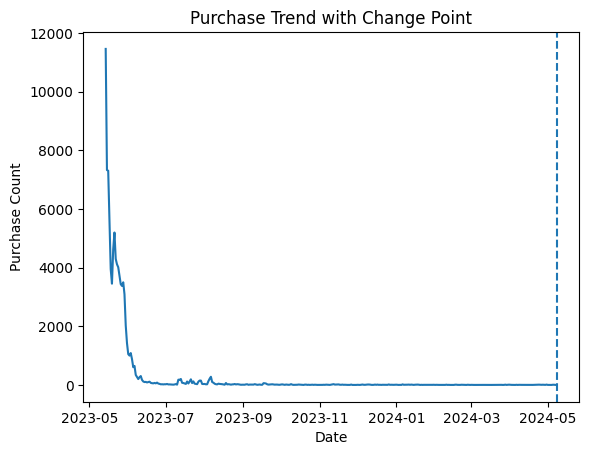

In [30]:
import matplotlib.pyplot as plt

plt.figure()

daily_purchase.plot()

plt.axvline(boundary_date, linestyle="--")

plt.title("Purchase Trend with Change Point")
plt.xlabel("Date")
plt.ylabel("Purchase Count")

plt.show()

In [ ]:
# 경계 찾기
import ruptures as rpt

signal = daily_purchase.values

algo = rpt.Binseg(model="l2").fit(signal)
result = algo.predict(n_bkps=1)   # 변화점 1개만

print(result)

[15, 326]


In [35]:
change_idx = result[0]
change_date = daily_purchase.index[change_idx]

print("경계 날짜:", change_date)

경계 날짜: 2023-05-29


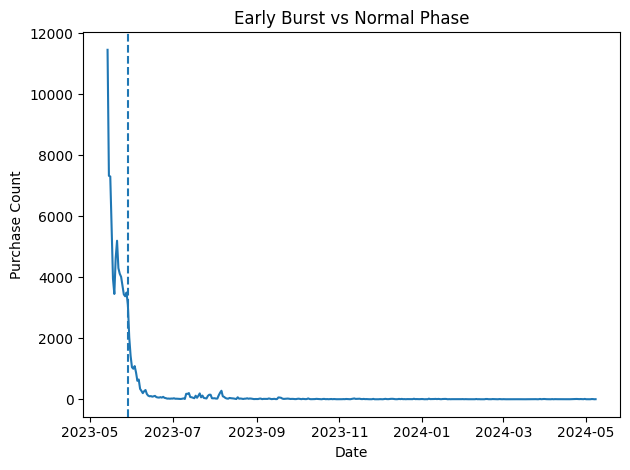

In [36]:
# 그래프 표시
import matplotlib.pyplot as plt

plt.figure()
daily_purchase.plot()

plt.axvline(change_date, linestyle="--")

plt.title("Early Burst vs Normal Phase")
plt.xlabel("Date")
plt.ylabel("Purchase Count")

plt.tight_layout()
plt.show()

In [38]:
import pandas as pd

change_date = pd.Timestamp(change_date)

In [39]:
payment["created_at"] = pd.to_datetime(payment["created_at"])

payment["period"] = payment["created_at"].apply(
    lambda x: "before" if x < change_date else "after"
)

In [40]:
buyer_cnt = (
    payment
    .groupby("period")["user_id"]
    .nunique()
    .reset_index(name="buyer_count")
)

buyer_cnt

,period,buyer_count
0,after,13443
1,before,48832


In [41]:
purchase_cnt = (
    payment
    .groupby("period")
    .size()
    .reset_index(name="purchase_count")
)

purchase_cnt

,period,purchase_count
0,after,19796
1,before,75344


In [42]:
repurchase = (
    payment
    .groupby(["period", "user_id"])
    .size()
    .reset_index(name="purchase_n")
)

repurchase["is_rebuyer"] = repurchase["purchase_n"] >= 2

In [43]:
rebuyer_cnt = (
    repurchase[repurchase["is_rebuyer"]]
    .groupby("period")["user_id"]
    .nunique()
    .reset_index(name="rebuyer_count")
)

rebuyer_cnt

,period,rebuyer_count
0,after,3395
1,before,12411


In [44]:
result = buyer_cnt.merge(rebuyer_cnt, on="period", how="left")

result["rebuyer_count"] = result["rebuyer_count"].fillna(0)

result["repurchase_rate"] = (
    result["rebuyer_count"] / result["buyer_count"]
)

result

,period,buyer_count,rebuyer_count,repurchase_rate
0,after,13443,3395,0.252548
1,before,48832,12411,0.254157


In [46]:
payment["created_at"] = pd.to_datetime(payment["created_at"])
daily_purchase.index = pd.to_datetime(daily_purchase.index)

In [47]:
daily_df = daily_purchase.reset_index()
daily_df.columns = ["date", "purchase"]

daily_df["period"] = daily_df["date"].apply(
    lambda x: "before" if x < change_date else "after"
)

daily_df.groupby("period")["purchase"].mean()

period
after       63.652733
before    5022.933333
Name: purchase, dtype: float64

In [48]:
daily_df.groupby("period")["purchase"].std()

period
after      255.642319
before    2196.767998
Name: purchase, dtype: float64

- 퍼널과 병합

In [50]:
import pandas as pd

BASE = "clean_vote_ver2/"

user = pd.read_csv(BASE + "processed_accounts_user.csv")
group = pd.read_csv(BASE + "processed_accounts_group.csv")
vote_record = pd.read_csv(BASE + "processed_userquestionrecord.csv")
payment = pd.read_csv(BASE + "processed_accounts_paymenthistory.csv")

- 전체 구매량 대비 비율

In [62]:
payment["created_at"] = pd.to_datetime(payment["created_at"])
change_date = pd.Timestamp(change_date)

In [63]:
payment["period"] = "after"
payment.loc[payment["created_at"] < change_date, "period"] = "before"

In [64]:
purchase_by_period = payment["period"].value_counts()

purchase_by_period

period
before    75344
after     19796
Name: count, dtype: int64

In [65]:
ratio = purchase_by_period / purchase_by_period.sum()

ratio

period
before    0.791928
after     0.208072
Name: count, dtype: float64